In [16]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict

sns.set_theme(style="whitegrid", context="paper")
sns.set_palette("coolwarm")

In [17]:
data_fama_french = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)
#data_stocks = pd.read_csv("data/characteristics_data_feb2017.csv")

In [18]:
data_fama_french["Date"] = pd.to_datetime(data_fama_french["Date"], format="%Y%m")
data_fama_french = data_fama_french.set_index("Date")

# data_fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
# leaving the data in percentage format to reduce float precision errors

data_fama_french

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,0.48
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,0.40
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,0.39


In [19]:
# data_stocks.drop(
#     columns=[
#         "idx",
#         "q10",
#         "q20",
#         "q50",
#         "prc",
#         "a2me",
#         "ato",
#         "beme",
#         "c",
#         "cto",
#         "d2a",
#         "dpi2a",
#         "e2p",
#         "fc2y",
#         "free_cf",
#         "investment",
#         "lturnover",
#         "noa",
#         "oa",
#         "ol",
#         "pcm",
#         "pm",
#         "prof",
#         "q",
#         "rna",
#         "roa",
#         "roe",
#         "s2p",
#         "sga2m",
#         "at",
#         "cum_return_12_2",
#         "cum_return_12_7",
#         "cum_return_1_0",
#         "cum_return_36_13",
#         "idio_vol",
#         "spread_mean",
#         "suv",
#         "rel_to_high_price",
#         "lev",
#     ],
#     inplace=True,
# )

# data_stocks.sort_values(by=["date"], ascending=[True], inplace=True)
# data_stocks["date"] = pd.to_datetime(data_stocks["date"])
# data_stocks.head()

Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [20]:
# X = data_fama_french.values.reshape(-1, 1)
# lengths = [len(data_fama_french)] * 6

# multivaraite time series
X = data_fama_french.values
lengths = [len(data_fama_french)]

In [21]:
rs = check_random_state(42)
# TODO add K-means initialization
aic = []
bic = []
lls = []
convergence_status = []
iterations = []
ns = [2, 3, 4, 5]


for n in ns:
    best_ll = None
    best_model = None
    for _ in range(30):
        h = GaussianHMM(
            n,
            n_iter=2000,
            tol=1e-6,
            random_state=rs,
            covariance_type="full",
            verbose=False,
        )
        h.fit(X, lengths)
        # TODO add out of sample validation, currently in sample
        score = h.score(X, lengths)
        if not best_ll or best_ll < score:
            best_ll = score
            best_model = h

    aic.append(best_model.aic(X))
    bic.append(best_model.bic(X))
    lls.append(best_model.score(X))
    convergence_status.append(best_model.monitor_.converged)
    iterations.append(best_model.monitor_.iter)


print("Convergence Status: ", convergence_status)
print("Iterations: ", iterations)

Model is not converging.  Current: -8231.263353957833 is not greater than -8231.263352641248. Delta is -1.316584530286491e-06
Model is not converging.  Current: -7875.941445130761 is not greater than -7875.94142480825. Delta is -2.0322510863479692e-05
Model is not converging.  Current: -7875.941439185904 is not greater than -7875.9414223982085. Delta is -1.678769513091538e-05
Model is not converging.  Current: -7875.941439001635 is not greater than -7875.941422423394. Delta is -1.657824122958118e-05
Model is not converging.  Current: -7887.633960318966 is not greater than -7887.633898400577. Delta is -6.191838929225923e-05
Model is not converging.  Current: -7887.633937372553 is not greater than -7887.633894789578. Delta is -4.2582974856486544e-05
Model is not converging.  Current: -7887.633928996635 is not greater than -7887.633886369665. Delta is -4.262697075319011e-05
Model is not converging.  Current: -7887.633935656747 is not greater than -7887.633888131758. Delta is -4.7524988985

Convergence Status:  [True, True, True, True]
Iterations:  [17, 55, 169, 56]


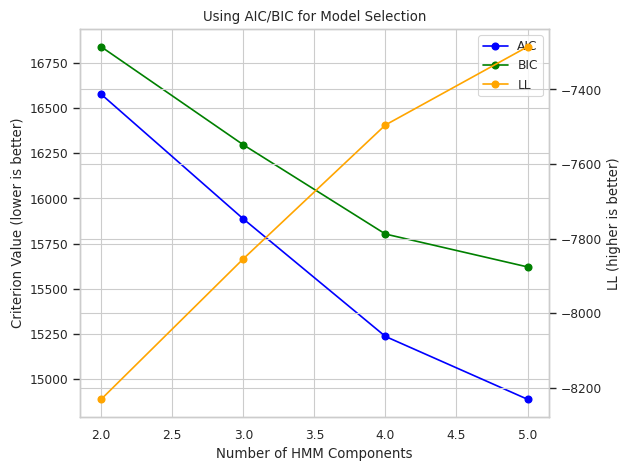

In [22]:
fig, ax = plt.subplots()
ln1 = ax.plot(ns, aic, label="AIC", color="blue", marker="o")
ln2 = ax.plot(ns, bic, label="BIC", color="green", marker="o")
ax2 = ax.twinx()
ln3 = ax2.plot(ns, lls, label="LL", color="orange", marker="o")

ax.legend(handles=ax.lines + ax2.lines)
ax.set_title("Using AIC/BIC for Model Selection")
ax.set_ylabel("Criterion Value (lower is better)")
ax2.set_ylabel("LL (higher is better)")
ax.set_xlabel("Number of HMM Components")
fig.tight_layout()

plt.show()

# TODO add heuristic to choose optimal number of components, currently visually finding the elbow

Zaključujemo da je 4 optimalan broj stanja

In [23]:
h = GaussianHMM(
    n_components=4, n_iter=10000, tol=1e-4, covariance_type="full", random_state=rs
)
h.fit(X, lengths=len(X))

hidden_states = h.predict(X, lengths=len(X))

In [24]:
def remap_hidden_states_by_covariance(h, hidden_states):
    cov_traces = [np.trace(c) for c in h.covars_]
    
    sorted_indices = np.argsort(cov_traces)
    
    h.means_ = h.means_[sorted_indices]
    h.covars_ = h.covars_[sorted_indices]
    h.transmat_ = h.transmat_[sorted_indices, :][:, sorted_indices]
    h.startprob_ = h.startprob_[sorted_indices]
    
    state_mapping = {old: new for new, old in enumerate(sorted_indices)}
    
    hidden_states = np.vectorize(state_mapping.get)(hidden_states)
    
    return hidden_states

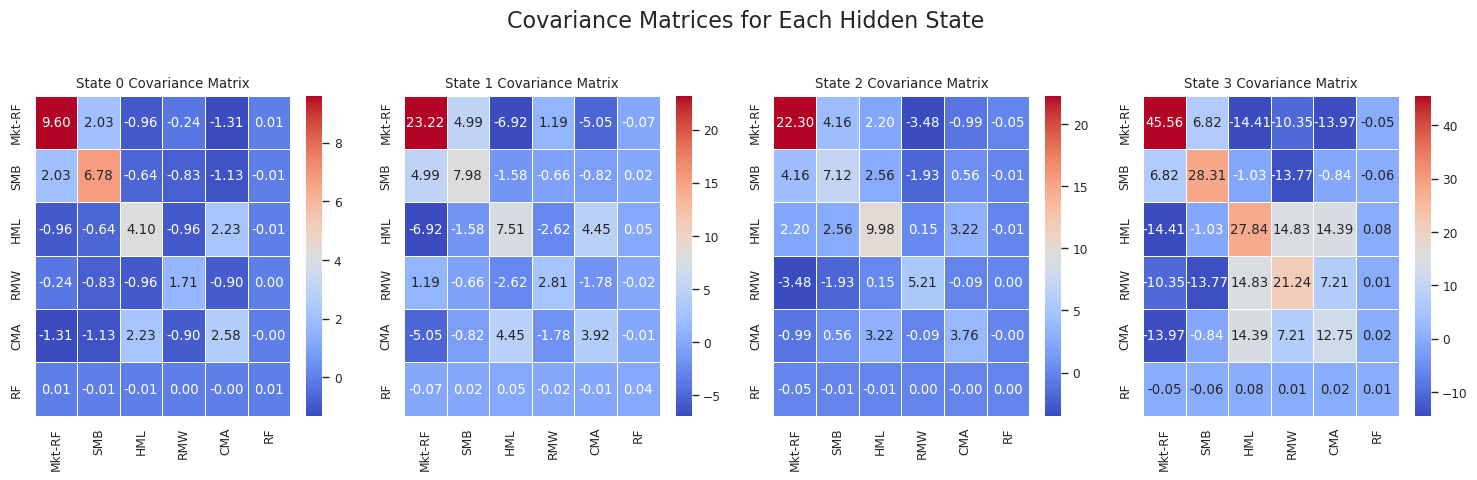

In [ ]:
# use previous function to remap the hidden states
hidden_states = remap_hidden_states_by_covariance(h, hidden_states)

covariance_matrices = h.covars_

factor_names = data_fama_french.columns.tolist()

num_states = len(covariance_matrices)
fig, axes = plt.subplots(1, num_states, figsize=(15, 5))

for i in range(num_states):
    cov_matrix = covariance_matrices[i]

    sns.heatmap(
        cov_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        ax=axes[i],
        xticklabels=factor_names,
        yticklabels=factor_names,
    )
    axes[i].set_title(f"State {i} Covariance Matrix")

plt.suptitle("Covariance Matrices for Each Hidden State", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

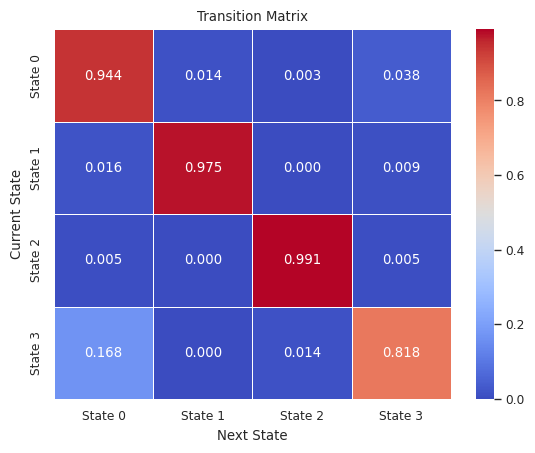

In [26]:
# plot transition matrix
fig, ax = plt.subplots()
sns.heatmap(
    h.transmat_,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    ax=ax,
    xticklabels=[f"State {i}" for i in range(num_states)],
    yticklabels=[f"State {i}" for i in range(num_states)],
)
ax.set_title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

In [27]:
# calculate the average length of each state
state_lengths = defaultdict(list)

current_state = hidden_states[0]
counter = 1
for state in hidden_states[1:]:
    if state == current_state:
        counter += 1
    else:
        state_lengths[current_state].append(counter)
        counter = 1
        current_state = state

# sorted keys
sorted_keys = sorted(state_lengths.keys())
state_lengths = {key: state_lengths[key] for key in sorted_keys}
average_lengths = {state: np.mean(lengths) for state, lengths in state_lengths.items()}

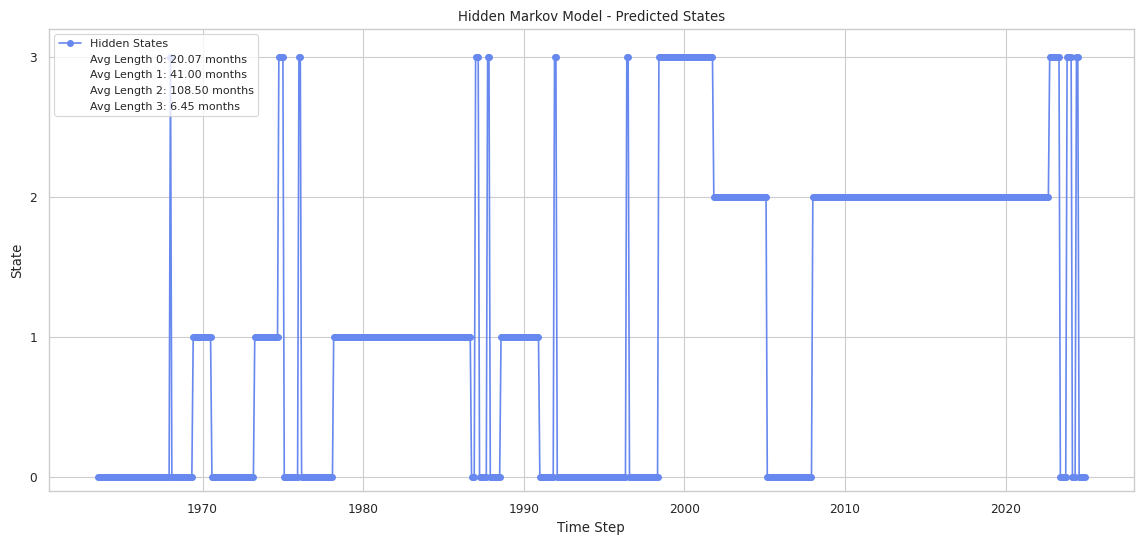

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(
    data_fama_french.index,
    hidden_states,
    label="Hidden States",
    marker="o",
    linestyle="-",
    markersize=4,
)
plt.title("Hidden Markov Model - Predicted States")
plt.xlabel("Time Step")
plt.ylim(-0.1, h.n_components - 0.8)
plt.ylabel("State")
plt.yticks(np.arange(h.n_components))

for state, lengths in average_lengths.items():
    plt.plot([], [], " ", label=f"Avg Length {state}: {lengths:.2f} months")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)

plt.show()

In [ ]:
model_2_states = GaussianHMM(
    n_components=2, n_iter=10000, tol=1e-4, covariance_type="full", random_state=rs
)
model_2_states.fit(X, lengths=len(X))

model_3_states = GaussianHMM(
    n_components=3, n_iter=10000, tol=1e-4, covariance_type="full", random_state=rs
)
model_3_states.fit(X, lengths=len(X))

In [ ]:
state_probs_2 = model_2_states.predict_proba(X, lengths=len(X))
state_probs_3 = model_3_states.predict_proba(X, lengths=len(X))
state_probs_4 = h.predict_proba(X, lengths=len(X))

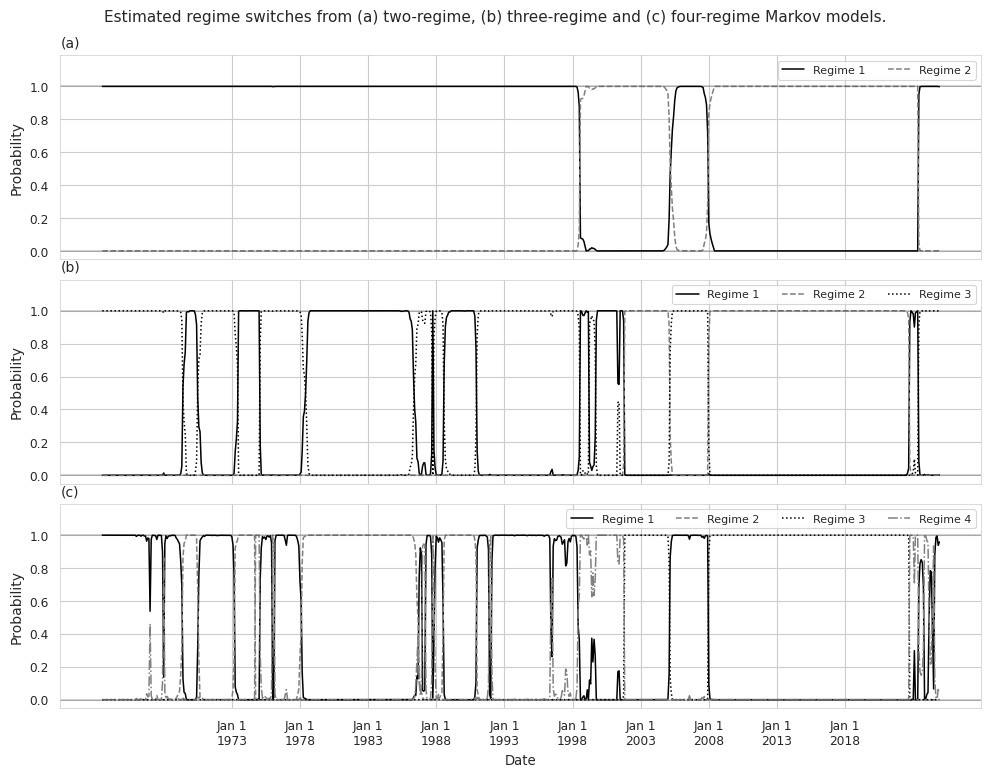

In [52]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.text(0.5, 0.95, 'Estimated regime switches from (a) two-regime, (b) three-regime and (c) four-regime Markov models.', 
         ha='center', fontsize=11)

line_styles = ['-', '--', ':', '-.']
colors = ['black', 'gray', 'black', 'gray']

titles = ['(a)', '(b)', '(c)']
probs = [state_probs_2, state_probs_3, state_probs_4]
n_regimes = [2, 3, 4]

for i, (ax, prob, n_regime) in enumerate(zip(axes, probs, n_regimes)):
    ax.set_title(titles[i], loc='left', fontsize=10)
    
    for j in range(n_regime):
        sns.lineplot(
            x=data_fama_french.index, 
            y=prob[:, j],
            ax=ax,
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f'Regime {j+1}'
        )
    
    ax.legend(loc='upper right', ncol=n_regime, frameon=True, fontsize="small")
    
    ax.set_ylim(-0.05, 1.19)
    ax.set_ylabel('Probability', fontsize=10)
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    ax.axhline(y=1, color='black', linestyle='-', alpha=0.2)

year_ticks = pd.date_range(start='1973-01-01', end='2018-01-01', freq='5YS')
axes[2].set_xticks(year_ticks)
axes[2].set_xticklabels([f'Jan 1\n{date.year}' for date in year_ticks])

sns.despine()

for ax in axes:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.1)
plt.savefig('regime_switches.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#TODO repeat with daily data